## 迁移学习

训练参数设置

In [51]:
pre_features_files = {'ResNet50':'ResNet50_pre_out.h5', 'Xception':'Xception_pre_out.h5', 'InceptionV3':'InceptionV3_pre_out.h5'}

composite_model = True
single_model = 'ResNet50'

# check training parameter
if not composite_model and single_model not in pre_features_files:
    print("%s not found in pre-trained models" %single_model)
else:
    if composite_model:
        print("will use composite model")
    else:
        print("will use %s model" %single_model)

will use composite model


### 载入数据

In [52]:
import h5py
import numpy as np
from sklearn.utils import shuffle
np.random.seed(66)

train_data = []
test_data = []

# #------- single pre-trained model
if not composite_model:
    with h5py.File(pre_features_files[single_model] , 'r') as h:
        train_data.append(np.array(h['train']))
        train_labels = np.array(h['label'])
        test_data.append(np.array(h['test']))
else:#-------- composite model
    for model_name in pre_features_files:
        with h5py.File(pre_features_files[model_name]) as h:
            train_data.append(np.array(h['train']))
            train_labels = np.array(h['label'])
            test_data.append(np.array(h['test']))

train_data = np.concatenate(train_data, axis=1)
test_data = np.concatenate(test_data, axis=1)

print("train shape:",train_data.shape)
print("train_data:",train_data[:5])
# 预存的X_train, y_train是按顺序存放的，前12500是猫，后12500是狗, 这里打乱顺序，使之随机存放
# Note: 打乱的是存放存放顺序，并不改变 X_train , y_train的对应关系
train_data, train_labels = shuffle(train_data, train_labels)

train shape: (25000, 6144)
train_data: [[0.0000000e+00 1.3600872e+01 1.2804574e+01 ... 2.1971479e-02
  0.0000000e+00 1.0562230e+00]
 [0.0000000e+00 3.4676161e-01 1.3490912e+00 ... 0.0000000e+00
  0.0000000e+00 1.5722100e+00]
 [0.0000000e+00 4.7338057e-02 1.8976200e+00 ... 0.0000000e+00
  0.0000000e+00 2.9515190e+00]
 [0.0000000e+00 8.6745272e+00 1.7706371e+01 ... 0.0000000e+00
  3.3145148e-01 1.3846457e+00]
 [0.0000000e+00 1.0520143e+01 2.6424284e+01 ... 0.0000000e+00
  0.0000000e+00 1.6271708e+00]]


### 构建模型

```
from keras.models import Sequential
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input

# from keras.applications import xception
input_tensor=Input(train_data.shape[1:])

model = Sequential()
model.add(Flatten(input_tensor))
model.add(Dense(1, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
        
 ```

In [53]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input
import numpy as np

np.random.seed(66)

input_tensor = Input(train_data.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### 在pre-train features上训练模型

In [54]:
model_hist = model.fit(train_data, train_labels,
                       batch_size=128,epochs=20,
                       validation_split = 0.2,
                       verbose=1
          )

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 4s 212us/step - loss: 3.8523 - acc: 0.6693 - val_loss: 3.8159 - val_acc: 0.6778
Epoch 2/20
20000/20000 [==============================] - 4s 193us/step - loss: 1.8623 - acc: 0.8191 - val_loss: 0.9424 - val_acc: 0.8890
Epoch 3/20
20000/20000 [==============================] - 4s 193us/step - loss: 0.8420 - acc: 0.9040 - val_loss: 0.2015 - val_acc: 0.9650
Epoch 4/20
20000/20000 [==============================] - 4s 191us/step - loss: 0.5756 - acc: 0.9274 - val_loss: 0.5802 - val_acc: 0.9274
Epoch 5/20
20000/20000 [==============================] - 4s 192us/step - loss: 0.5098 - acc: 0.9323 - val_loss: 0.1768 - val_acc: 0.9704
Epoch 6/20
20000/20000 [==============================] - 4s 194us/step - loss: 0.4527 - acc: 0.9418 - val_loss: 0.2240 - val_acc: 0.9674
Epoch 7/20
20000/20000 [==============================] - 4s 193us/step - loss: 0.4237 - acc: 0.9470 - val_loss: 0.1710 - v

In [55]:
if composite_model:
    logpath = 'log/composite_mode'
    
else:
    logpath = 'log/'+single_model
    
model.save(logpath+'.h5')
with open(logpath+'_hist.txt','w') as f:
    f.write(str(model_hist.history))

{'val_loss': [3.8159383949279784, 0.9424129034042359, 0.20147865808857549, 0.5802018656305968, 0.17675653689699192, 0.22401397658131317, 0.17100528118861782, 0.2606603018400558, 0.2129590988750564, 1.2290830436706544, 0.43206852625608444, 0.21556989591969122, 0.17122339642299284, 0.6305705663053457, 0.6952169847430489, 0.8834411393165589, 0.15889457863224613, 0.1765981456960546, 0.4089093964899885, 0.36357489967700096], 'val_acc': [0.6778, 0.889, 0.965, 0.9274, 0.9704, 0.9674, 0.9704, 0.9582, 0.9652, 0.8686, 0.949, 0.9698, 0.9732, 0.9258, 0.9202, 0.9054, 0.976, 0.9694, 0.9474, 0.961], 'loss': [3.852318737792969, 1.862259707927704, 0.8420135493278503, 0.5755771483302117, 0.509756089656183, 0.45274940440654754, 0.42368918227239044, 0.38684964690208434, 0.4103355574206216, 0.40684875766038897, 0.38169142669439315, 0.37072995982170104, 0.3548784342288971, 0.3745948179435916, 0.33977001896500586, 0.3186410650257021, 0.3327444457407284, 0.362974061240349, 0.38966800240576266, 0.3172710598319

c:\programdata\anaconda2\envs\style-transfer\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


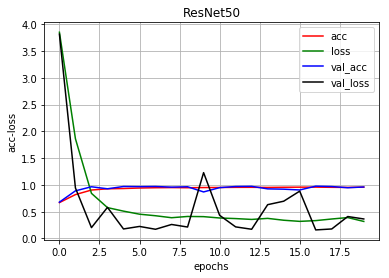

In [56]:
## 查看 history
import matplotlib.pyplot as plt

def read_history_from_file(filename):
    f = open(filename,'r')
    rdbuf = f.read()
    hist = eval(rdbuf)
    f.close()
    
    return hist

def show_history(hist, title_name):
    # epoch as x-axis 
    epochs = range(len(hist['acc']))
    
    fig, ax = plt.subplots()
    
    # acc
    ax.plot(epochs, hist['acc'], 'r', label='acc')
    # loss
    ax.plot(epochs, hist['loss'], 'g', label='loss')
    # val_acc
    ax.plot(epochs, hist['val_acc'], 'b', label='val_acc')
    # val_loss
    ax.plot(epochs, hist['val_loss'], 'k', label='val_loss')
    
    ax.set(xlabel='epochs', ylabel='acc-loss',title=title_name)
    
    ax.legend(loc='best', fancybox=True, fontsize=10)
            
    ax.grid(True)
    
    fig.show()
    
hist = read_history_from_file(logpath+'_hist.txt')
print(hist)
show_history(hist, single_model)

### 用拟合后的模型预测

In [49]:
y_pred = model.predict(test_data, verbose=1)

12500/12500 [==============================] - 0s 23us/step


预测结果写入kaggle sample_submission.csv

In [50]:
y_pred = y_pred.clip(min=0.005, max=0.995)

import pandas as pd
from keras.preprocessing.image import *

df = pd.read_csv("sample_submission.csv")

gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("pre-test", (224, 224), shuffle=False, 
                                         batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('pred.csv', index=None)
df.head(10)

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: 'pre-test'

### 模型可视化

In [1]:
from graphviz import Digraph

dot = Digraph(comment='The Model Chart')

dot.attr('node',shape='record')

dot.node('IN', 'Input|images')
dot.node('PRE-R', 'ResNet50|{input:|output:}|{(224, 224, 3)|(2048)}')
dot.node('PRE-X', 'Xception|{input:|output:}|{(299, 299, 3)|(2048)}')
dot.node('PRE-I', 'InceptionV3|{input:|output:}|{(299, 299, 3)|(2048)}')
dot.edge('IN', 'PRE-R')
dot.edge('IN', 'PRE-X')
dot.edge('IN', 'PRE-I')
# dot.edges(['AB', 'AL'])
# dot.edge('PRE-R', 'PRE-X', constraint='false')

dot.node('L3', 'Flatten|{input:|output:}|{(2048,3)|2048*3=6144}')
dot.edge('PRE-R', 'L3')
dot.edge('PRE-X', 'L3')
dot.edge('PRE-I', 'L3')

dot.node('L4', 'Dropout|Rate:|0.5')
dot.node('L5', 'Output|{input:|output:}|{6144|1}')
dot.edge('L3', 'L4')
dot.edge('L4', 'L5')

print(dot.source)
dot.render('model-table.gv', view=True)

// The Model Chart
digraph {
	node [shape=record]
	IN [label="Input|images"]
	"PRE-R" [label="ResNet50|{input:|output:}|{(224, 224, 3)|(2048)}"]
	"PRE-X" [label="Xception|{input:|output:}|{(299, 299, 3)|(2048)}"]
	"PRE-I" [label="InceptionV3|{input:|output:}|{(299, 299, 3)|(2048)}"]
	IN -> "PRE-R"
	IN -> "PRE-X"
	IN -> "PRE-I"
	L3 [label="Flatten|{input:|output:}|{(2048,3)|2048*3=6144}"]
	"PRE-R" -> L3
	"PRE-X" -> L3
	"PRE-I" -> L3
	L4 [label="Dropout|Rate:|0.5"]
	L5 [label="Output|{input:|output:}|{6144|1}"]
	L3 -> L4
	L4 -> L5
}


'model-table.gv.pdf'